In [45]:
#Import libraries
import pandas as pd
import numpy as np
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

### Feature inspection

In [11]:
#Read dataset
df = pd.read_csv('src/data/clean/data_clean.csv', encoding='ISO-8859-1')
df = df[['Severity'] + [col for col in df.columns if col != 'Severity']]

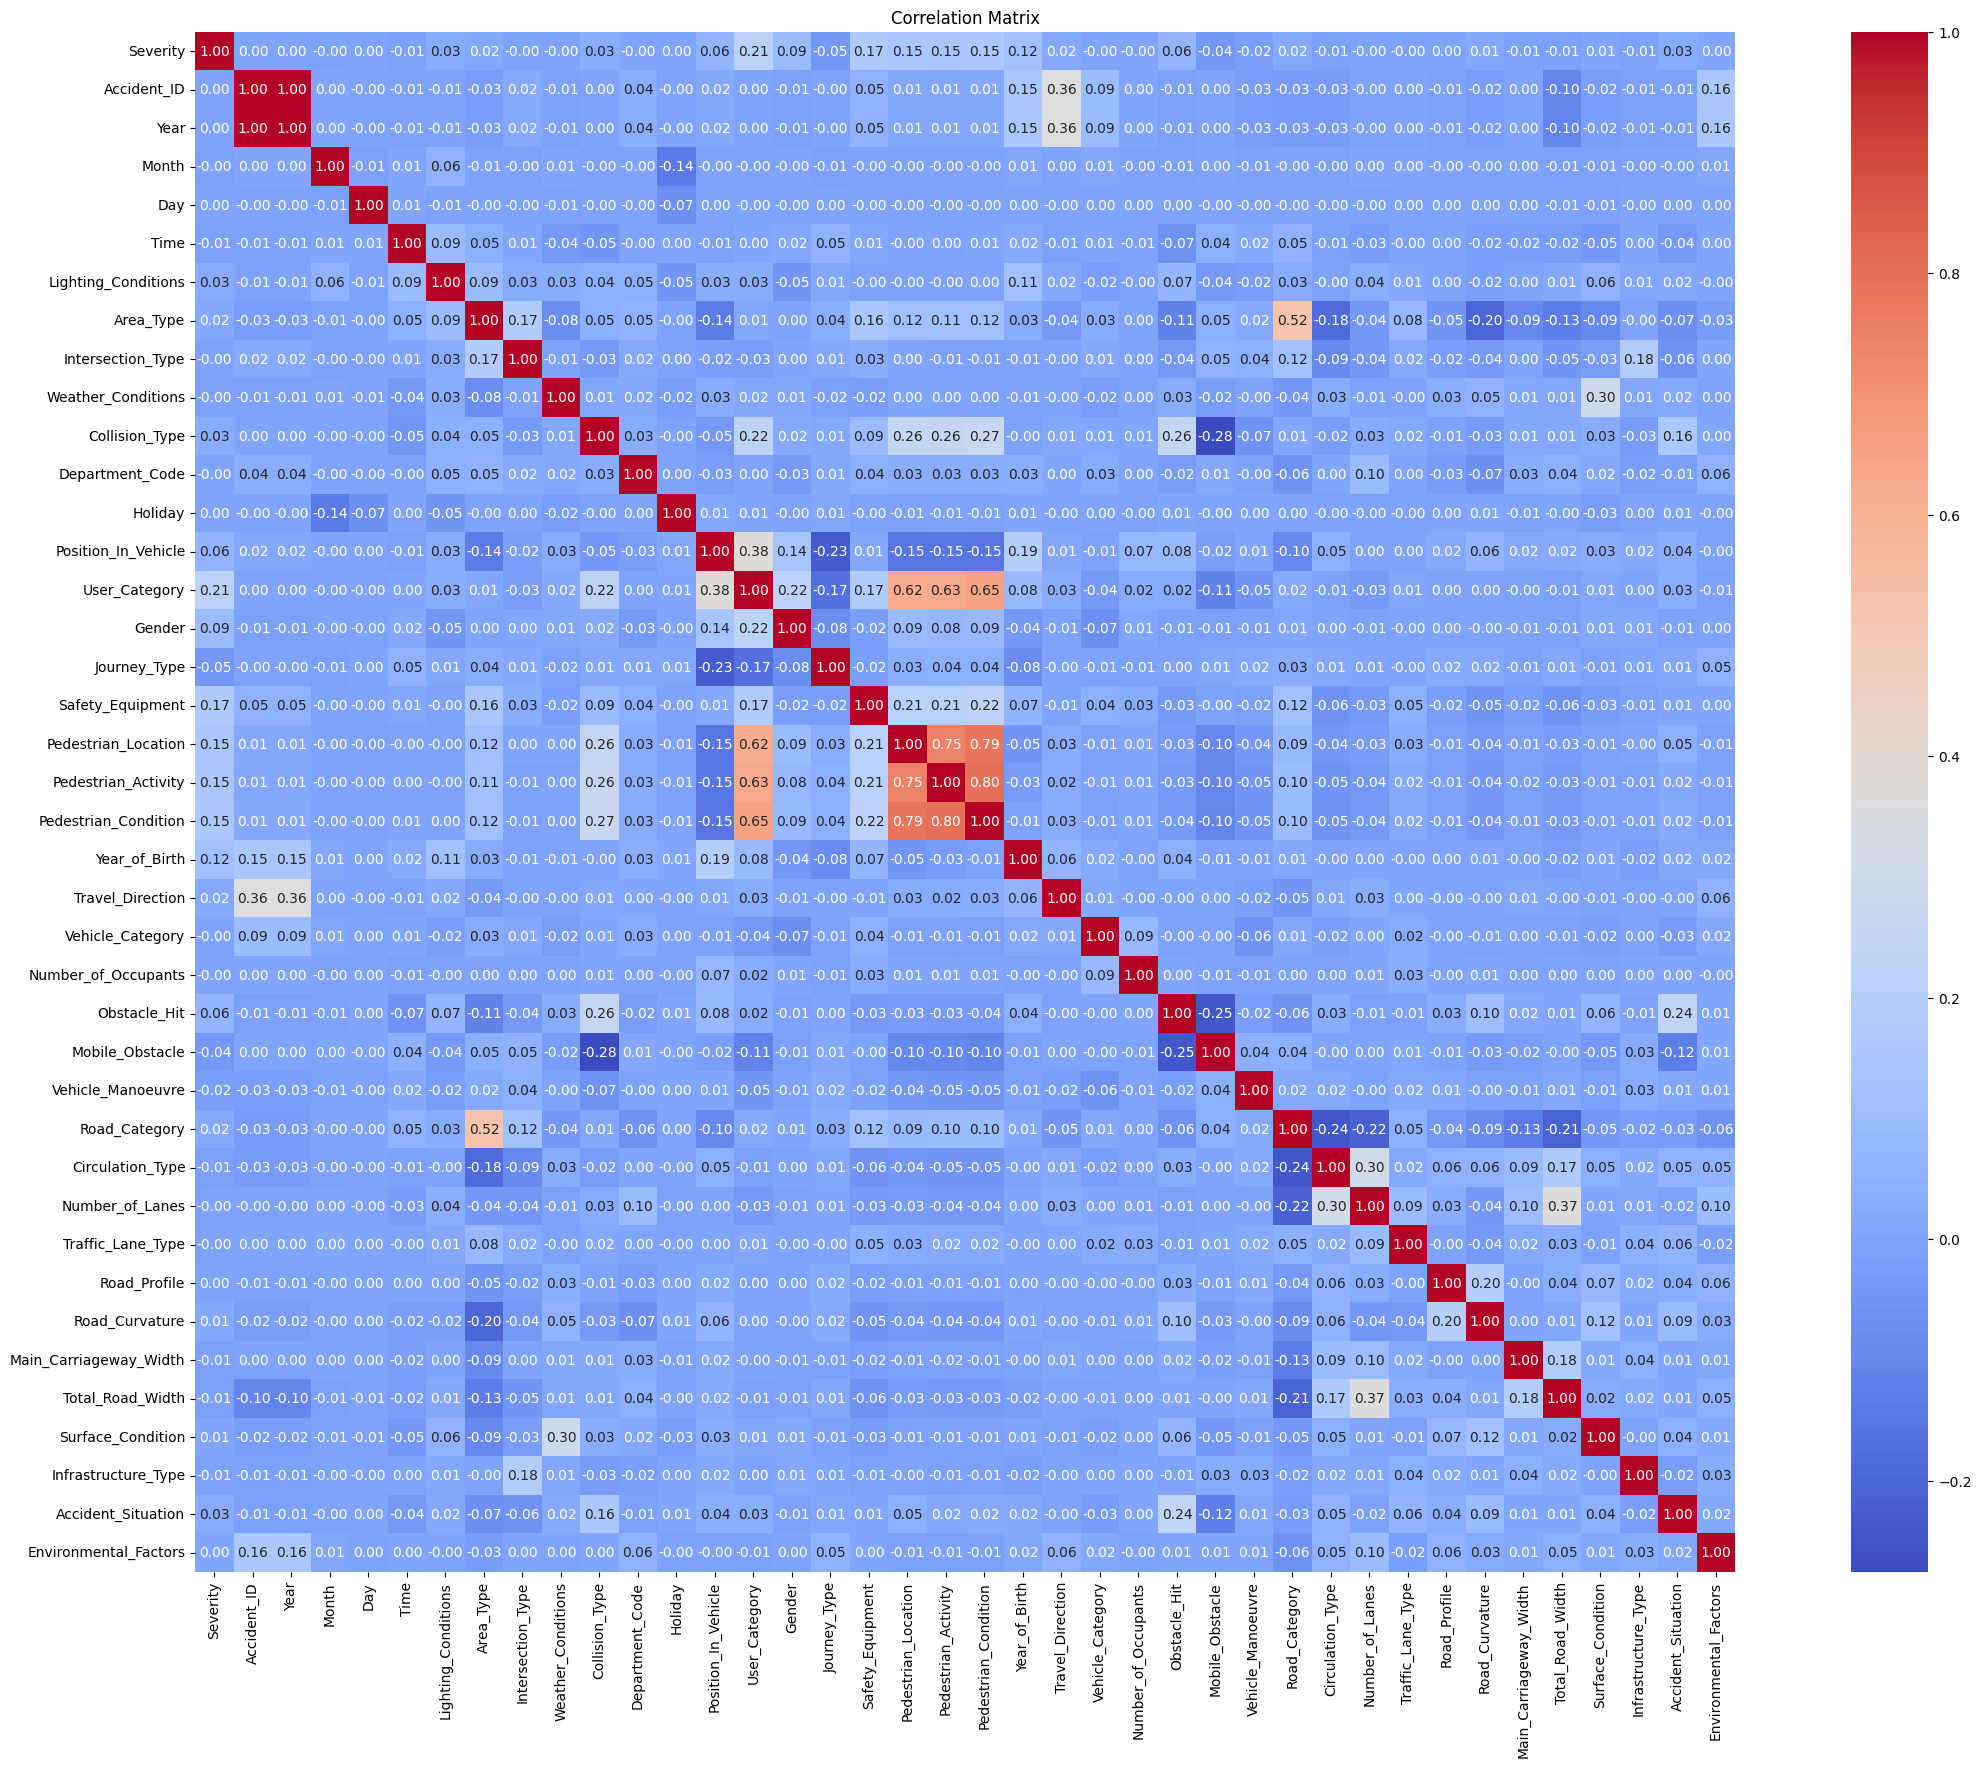

In [4]:
#Visualize correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [5]:
#Identifying the features that are most correlated with target
severity_correlation = correlation_matrix['Severity'].abs().sort_values(ascending=False)
print(severity_correlation[0:10])

Severity                1.000000
User_Category           0.213245
Safety_Equipment        0.165475
Pedestrian_Condition    0.154024
Pedestrian_Activity     0.151212
Pedestrian_Location     0.150411
Year_of_Birth           0.115252
Gender                  0.093325
Obstacle_Hit            0.064136
Position_In_Vehicle     0.058997
Name: Severity, dtype: float64


In [6]:
#Identifying the features that are least correlated with target
severity_correlation = correlation_matrix['Severity'].abs().sort_values()
print(severity_correlation)

Day                       0.000370
Department_Code           0.000429
Vehicle_Category          0.000475
Road_Profile              0.000588
Year                      0.000721
Accident_ID               0.000722
Number_of_Occupants       0.001201
Number_of_Lanes           0.001428
Traffic_Lane_Type         0.001910
Intersection_Type         0.002068
Holiday                   0.002336
Month                     0.002897
Weather_Conditions        0.004135
Environmental_Factors     0.004804
Surface_Condition         0.007718
Infrastructure_Type       0.008847
Main_Carriageway_Width    0.009184
Total_Road_Width          0.011631
Road_Curvature            0.014226
Circulation_Type          0.014234
Time                      0.014385
Area_Type                 0.016178
Vehicle_Manoeuvre         0.016720
Travel_Direction          0.022265
Road_Category             0.023450
Lighting_Conditions       0.026605
Accident_Situation        0.028440
Collision_Type            0.032239
Mobile_Obstacle     

In [12]:
# Identifying features that are correlated

# Find pairs of features with high correlation
high_correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to DataFrame for better visualization
high_correlation_df = pd.DataFrame(high_correlation_pairs, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])
print(high_correlation_df)

#Drop Accident_ID, Area_Type, Pedestrian_Activity, Pedestrian_Condition, Pedestrian_Location

              Feature 1            Feature 2  Correlation Coefficient
0                  Year          Accident_ID                 1.000000
1   Pedestrian_Location        User_Category                 0.620943
2   Pedestrian_Activity        User_Category                 0.630757
3   Pedestrian_Activity  Pedestrian_Location                 0.747287
4  Pedestrian_Condition        User_Category                 0.650615
5  Pedestrian_Condition  Pedestrian_Location                 0.785054
6  Pedestrian_Condition  Pedestrian_Activity                 0.796424
7         Road_Category            Area_Type                 0.524858


### Feature identification

In [ ]:
#Drop identified columns (highly correlated features)
df.drop(['Accident_ID', 'Area_Type', 'Pedestrian_Activity', 'Pedestrian_Condition', 'Pedestrian_Location'], axis = 1, inplace = True)

In [16]:
#Combining columns - Driver_Age
df['Driver_Age'] = 2000 + df['Year'] - df['Year_of_Birth']
df.drop('Year_of_Birth', axis = 1, inplace = True)

In [18]:
#Time features - Time_of_day
df['Hour'] = df['Time'] // 100
df['Minute'] = df['Time'] % 100
df['Time_of_Day'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3], right=False).astype(int)

#Date features - Day_of_week
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].apply(lambda row: f"{int(row.iloc[0]):02d}-{int(row.iloc[1]):02d}-{int(row.iloc[2]):02d}", axis=1), 
                           format='%y-%m-%d', errors='coerce')
df['Day_of_Week'] = df['Date'].dt.dayofweek

df.drop(['Hour', 'Minute', 'Time', 'Date', 'Year', 'Month', 'Day'], axis = 1, inplace = True)

In [29]:
#Combine width features - Road_Width_Proportion
df['Road_Width_Proportion'] = df.apply(
    lambda row: row['Main_Carriageway_Width'] / row['Total_Road_Width'] 
    if row['Total_Road_Width'] != 0 else 0, axis=1
)

df = df.drop(['Main_Carriageway_Width', 'Total_Road_Width'], axis=1)

In [30]:
#Identifying the features that are least correlated with target
correlation_matrix = df.corr()
severity_correlation = correlation_matrix['Severity'].abs().sort_values()
print(severity_correlation)

Department_Code          0.000429
Vehicle_Category         0.000475
Road_Profile             0.000588
Number_of_Occupants      0.001201
Number_of_Lanes          0.001428
Traffic_Lane_Type        0.001910
Intersection_Type        0.002068
Holiday                  0.002336
Weather_Conditions       0.004135
Environmental_Factors    0.004804
Road_Width_Proportion    0.004999
Day_of_Week              0.006926
Surface_Condition        0.007718
Infrastructure_Type      0.008847
Time_of_Day              0.013639
Road_Curvature           0.014226
Circulation_Type         0.014234
Vehicle_Manoeuvre        0.016720
Travel_Direction         0.022265
Road_Category            0.023450
Lighting_Conditions      0.026605
Accident_Situation       0.028440
Collision_Type           0.032239
Mobile_Obstacle          0.042814
Journey_Type             0.045969
Position_In_Vehicle      0.058997
Obstacle_Hit             0.064136
Gender                   0.093325
Driver_Age               0.116220
Safety_Equipme

### Training simple model (RandomForest) to see feature importance

In [19]:
X = df.drop(columns=['Severity'])
y = df['Severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Modelling - Random Forest
rf_model = RandomForestClassifier(n_estimators=30, max_depth=5, min_samples_leaf=5, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=30,
                       random_state=42)

In [28]:
# Modelling - Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [33]:
#Get feature importance - Random Forest
importance = rf_model.feature_importances_

#Create a DataFrame
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

#Sort by importance
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

print(feature_importance_df_rf)

                   Feature  Importance
10        Safety_Equipment    0.448008
7            User_Category    0.091589
29              Driver_Age    0.085822
17           Road_Category    0.072996
14            Obstacle_Hit    0.057110
6      Position_In_Vehicle    0.049966
3           Collision_Type    0.046499
8                   Gender    0.030956
15         Mobile_Obstacle    0.020950
19         Number_of_Lanes    0.015271
9             Journey_Type    0.014869
12        Vehicle_Category    0.014451
27      Accident_Situation    0.013116
4          Department_Code    0.010687
18        Circulation_Type    0.008938
22          Road_Curvature    0.006458
1        Intersection_Type    0.004401
23  Main_Carriageway_Width    0.002274
24        Total_Road_Width    0.001661
30             Time_of_Day    0.001240
0      Lighting_Conditions    0.000769
25       Surface_Condition    0.000725
16       Vehicle_Manoeuvre    0.000537
20       Traffic_Lane_Type    0.000149
13     Number_of_Occupant

In [34]:
#Get feature importance - Decision Tree
importance = dt_model.feature_importances_

#Create a DataFrame
feature_importance_df_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

#Sort by importance
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

print(feature_importance_df_dt)

                   Feature  Importance
10        Safety_Equipment    0.473262
7            User_Category    0.222148
17           Road_Category    0.101243
14            Obstacle_Hit    0.063916
4          Department_Code    0.051496
3           Collision_Type    0.044597
8                   Gender    0.019086
12        Vehicle_Category    0.013830
15         Mobile_Obstacle    0.004992
19         Number_of_Lanes    0.004355
29              Driver_Age    0.001076
6      Position_In_Vehicle    0.000000
0      Lighting_Conditions    0.000000
5                  Holiday    0.000000
1        Intersection_Type    0.000000
2       Weather_Conditions    0.000000
13     Number_of_Occupants    0.000000
11        Travel_Direction    0.000000
9             Journey_Type    0.000000
16       Vehicle_Manoeuvre    0.000000
20       Traffic_Lane_Type    0.000000
21            Road_Profile    0.000000
22          Road_Curvature    0.000000
18        Circulation_Type    0.000000
23  Main_Carriageway_Widt

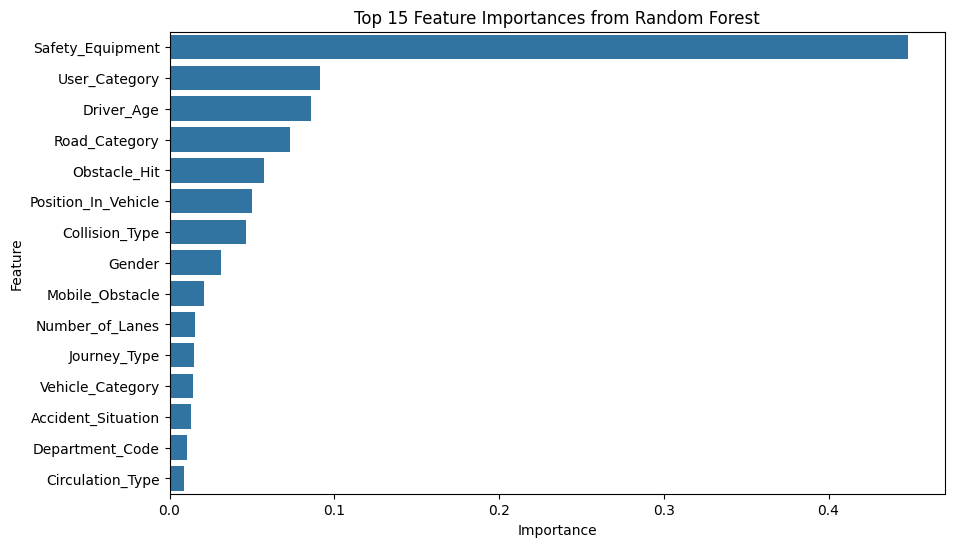

In [39]:
# Visualize features for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15))
plt.title('Top 15 Feature Importances from Random Forest')
plt.show()

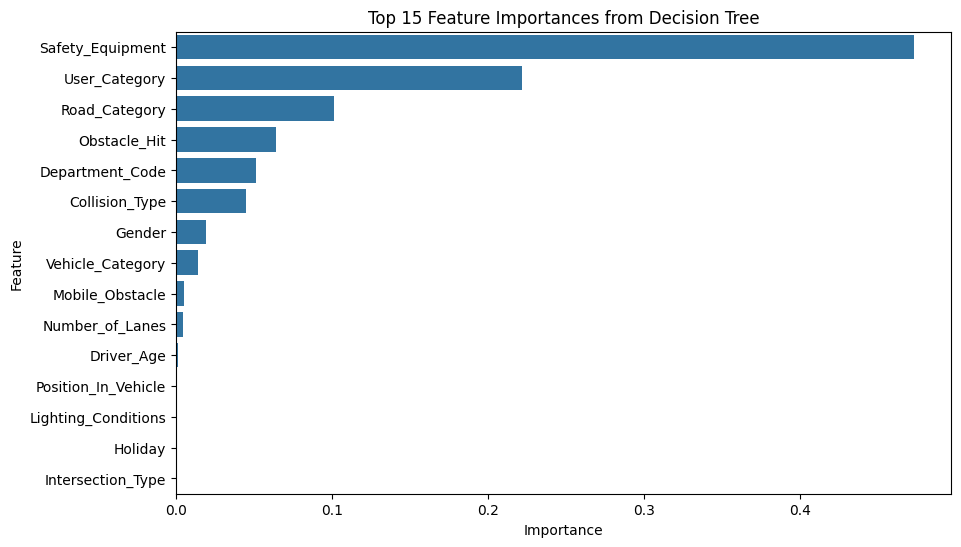

In [37]:
# Visualize features for Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dt.head(15))
plt.title('Top 15 Feature Importances from Decision Tree')
plt.show()

In [ ]:
# Predictions - Random Forest
y_pred = rf_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.89      0.73    415698
           2       0.00      0.00      0.00     23442
           3       0.57      0.12      0.19    189204
           4       0.56      0.55      0.56    335786

    accuracy                           0.60    964130
   macro avg       0.44      0.39      0.37    964130
weighted avg       0.57      0.60      0.55    964130



In [32]:
# Predictions - Decision Tree
y_pred = dt_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.84      0.74    415698
           2       0.00      0.00      0.00     23442
           3       0.51      0.27      0.35    189204
           4       0.55      0.55      0.55    335786

    accuracy                           0.61    964130
   macro avg       0.43      0.41      0.41    964130
weighted avg       0.58      0.61      0.58    964130



12 features in common (Safety_Equipment, User_Category, Road_Category, Department_Code, Collision_Type, Vehicle_Category, Number_of_Lanes, Driver_Age, Position_In_Vehicle, Obstacle_Hit, Mobile_Obstacle, Gender) + 3 features (Time_of_Day, Intersection_Type, Journey_Type) to add temporal and spatial information

### Finalizing feature extraction

In [43]:
#Choosing 15 most important features
df_final = df[['Severity','Driver_Age', 'Safety_Equipment', 'Department_Code', 'Mobile_Obstacle', 'Vehicle_Category', 'Position_In_Vehicle', 'Collision_Type', 'Number_of_Lanes', 'Time_of_Day', 'Journey_Type', 'Obstacle_Hit',
               'Road_Category', 'Gender', 'User_Category', 'Intersection_Type']]
df_final = df_final.drop_duplicates()

In [ ]:
#Check missing values and duplicates
print(df_final.isna().sum().sum())
print(df_final.duplicated().sum())

0
0


In [47]:
#Save preprocessed data
csv_path = 'src/data/final/data_final.csv'
df_final.to_csv(csv_path, index=False, encoding='ISO-8859-1')

#Create a zip file and add the CSV file to it
zip_path = 'src/data/final/data_final.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, arcname='data_final.csv')